In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import sys
sys.path.append(os.path.abspath('.'))
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))

import cv2
import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import pandas as pd
from tqdm.notebook import tqdm
from scipy import ndimage
import skimage
import skimage.filters

from torchvision.transforms import functional as F

from IPython.display import display, Markdown

from simple_relational_reasoning.embeddings.containment_support_dataset import ContainmentSupportDataset

from simple_relational_reasoning.embeddings.stimuli import build_differet_shapes_stimulus_generator, build_split_text_stimulus_generator, build_random_color_stimulus_generator,\
    find_non_empty_indices, EMPTY_TENSOR_PIXEL, UNNORMALIZE
from simple_relational_reasoning.embeddings.triplets import QuinnTripletGenerator,\
    NoReferenceEquidistantTripletGenerator, NoReferenceDiagonalTripletGenerator,\
    SameHalfTripletGenerator, SameQuadrantTripletGenerator, TSNEStimuliSetGenerator, ABOVE_BELOW_RELATION, BETWEEN_RELATION

In [3]:

FIGURE_TEMPLATE = r'''\begin{{figure}}[!htb]
% \vspace{{-0.225in}}
\centering
\includegraphics[width=\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
% \vspace{{-0.2in}}
\end{{figure}}
'''
WRAPFIGURE_TEMPLATE = r'''\begin{{wrapfigure}}{{r}}{{0.5\linewidth}}
\vspace{{-.3in}}
\begin{{spacing}}{{1.0}}
\centering
\includegraphics[width=0.95\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
\end{{spacing}}
% \vspace{{-.25in}}
\end{{wrapfigure}}'''

SAVE_PATH_PREFIX = 'figures'


def save_plot(save_path, bbox_inches='tight', should_print=False, should_prefix=True):
    if save_path is not None:
        save_path = os.path.abspath(save_path)
        save_path_no_ext = os.path.splitext(save_path)[0]
        if should_print:
            print('Figure:\n')
            print(FIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
            print('\nWrapfigure:\n')
            print(WRAPFIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
            print('')
        
        if not save_path.startswith(SAVE_PATH_PREFIX) and should_prefix:
            save_path = os.path.join(SAVE_PATH_PREFIX, save_path)
        
        folder, filename = os.path.split(save_path)
        os.makedirs(folder, exist_ok=True)
        plt.savefig(save_path, bbox_inches=bbox_inches, facecolor=plt.gcf().get_facecolor(), edgecolor='none')

In [4]:
reference_positions = [(105, 100)]

def plot_generator_examples(generator, ref_pos=reference_positions):
    plt.figure(figsize=(generator.n_target_types * 2.5, 3))

    for i in range(generator.n_target_types):
        x = generator.generate((80, 100 + (i * 20)), ref_pos, target_index=i)
        ax = plt.subplot(1, generator.n_target_types, i +1)
        ax.imshow(x.permute(1, 2, 0).numpy())


    plt.show()

def plot_triplets(triplets, plot_midlines=False, plot_diagonals=False, add_titles=True, save_path=None, custom_titles=None,
    row_titles=None, title_kwargs=None, title_every_image=False, suptitle=None):
    n = triplets.shape[0]
    k = triplets.shape[1]

    if title_kwargs is None:
        title_kwargs = {}

    fig = plt.figure(figsize=(3 * k, 3.1 * n))
    fig.patch.set_facecolor('white')

    for row in range(n):
        for col in range(k):
            ax = plt.subplot(n, k, (k * row) + col + 1)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(triplets[row, col].permute(1, 2, 0).numpy())

            if plot_midlines:
                ax.axhline(y=triplets.shape[-2] // 2, color='black', linestyle='--', alpha=0.5)
                ax.axvline(x=triplets.shape[-1] // 2, color='black', linestyle='--', alpha=0.5)
            
            if plot_diagonals:
                ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='black', linestyle='--', alpha=0.5)
                ax.plot([1, 0], [0, 1], transform=ax.transAxes, color='black', linestyle='--', alpha=0.5)

            if add_titles:
                title = None

                if title_every_image and custom_titles is not None:
                    title = custom_titles[row][col]

                elif row == 0:
                    if custom_titles is not None:
                        title = custom_titles[col]
                    elif col == k - 1:
                        title = 'Different Relation'
                    elif col == k - 2:
                        title = 'Same Relation'
                    else:
                        title = f'Habituation #{col + 1}'

                if title is not None:    
                    ax.set_title(title, **title_kwargs)

                if row_titles is not None and col == 0:
                    ax.set_ylabel(row_titles[row], **title_kwargs)

    if suptitle is not None:
        suptitle_kwargs = {**title_kwargs}
        if 'fontsize' in suptitle_kwargs:
            suptitle_kwargs['fontsize'] *= 1.5
        else:
            suptitle_kwargs['fontsize'] = 24
        plt.suptitle(suptitle, **suptitle_kwargs)

    fig.tight_layout()

    if save_path is not None:
        save_plot(save_path)

    plt.show()

def plot_cropped_centered_triplets(triplets, canvas_size=(3, 200, 200), edge_color=(1, 0, 0)):
    n = triplets.shape[0]
    k = triplets.shape[1]

    if not isinstance(edge_color, torch.Tensor):
        edge_color = torch.tensor(edge_color, dtype=torch.float32).view(3, 1)

    fig = plt.figure(figsize=(2 * k, 2 * n))
    fig.patch.set_facecolor('white')

    for row in range(n):
        for col in range(k):
            ax = plt.subplot(n, k, (k * row) + col + 1)
            ax.set_xticks([])
            ax.set_yticks([])

            img = triplets[row, col]
            r1, r2, c1, c2 = find_non_empty_indices(img, EMPTY_TENSOR_PIXEL, color_axis=0)
            img = img[:, r1:r2, c1:c2]
            canvas = torch.ones(*canvas_size)
            h = r2 - r1
            w = c2 - c1
            h_start = torch.div(canvas_size[1] - h, 2, rounding_mode='floor')
            w_start = torch.div(canvas_size[2] - w, 2, rounding_mode='floor')
            canvas[:, h_start:h_start + h, w_start:w_start + w] = img
            canvas[:, h_start - 1, w_start:w_start + w] = edge_color
            canvas[:, h_start + h, w_start:w_start + w] = edge_color
            canvas[:, h_start:h_start + h, w_start - 1] = edge_color
            canvas[:, h_start:h_start + h, w_start + w] = edge_color
            ax.imshow(canvas.permute(1, 2, 0).numpy())

            ax.set_title(f'{h} x {w} = {h * w}')

    fig.tight_layout()

    plt.show()

FLIPS = (
    lambda x: x,
    F.hflip,
    F.vflip,
    lambda x: F.hflip(F.vflip(x))
)

FLIP_NAMES = ('None', 'Horizontal', 'Vertical', 'Both')


def plot_flipped_versions(base_images, base_image_names, save_path=None,
    flips=FLIPS, flip_names=FLIP_NAMES, text_kwargs=None):

    if text_kwargs is None:
        text_kwargs = {}
    
    k = len(base_images)
    n = len(flips)

    fig = plt.figure(figsize=(2 * k, 2 * n))
    fig.patch.set_facecolor('white')

    for row in range(n):
        for col in range(k):
            ax = plt.subplot(n, k, (k * row) + col + 1)
            ax.set_xticks([])
            ax.set_yticks([])

            ax.imshow(flips[row](base_images[col]).permute(1, 2, 0).numpy())

            if row == 0:
                ax.set_title(base_image_names[col], **text_kwargs)

            if col == 0:
                ax.set_ylabel(flip_names[row], **text_kwargs)

    fig.tight_layout()

    if save_path is not None:
        save_plot(save_path, should_prefix=False)

    plt.show()


In [5]:
dataset = ContainmentSupportDataset('/Users/guydavidson/projects/BlockWorld/outputs/containment_v3_flapless')
dataset.dataset.shape

100%|██████████| 4096/4096 [02:45<00:00, 24.78it/s]


torch.Size([4096, 5, 3, 224, 224])

In [6]:
df = pd.read_csv('../containment_support_outputs/dataframes/v3_df.csv')
# df.drop(columns=['Unnamed: 0'], inplace=True)
print(df.shape)
df.head()

(49152, 32)


/Users/guydavidson/opt/anaconda3/envs/torch/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3397: DtypeWarning: Columns (3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,full_model_name,model,training,flip,dino,configuration_index,example_index,reference_object,target_object,containment_high_containment_cos,...,high_containment_vs_far_behind,high_containment_vs_far_behind_diff,high_containment_vs_far_behind_ratio,high_containment_vs_support,high_containment_vs_support_diff,high_containment_vs_support_ratio,behind_similar,far_behind_similar,support_similar,high_containment_similar
0,mobilenet-saycam(S),mobilenet,saycam(S),NaN,NaN,0,0,Basket,BeachBall,0.774233,...,True,0.005932,1.007721,True,0.020006,1.026526,False,False,False,True
1,mobilenet-saycam(S),mobilenet,saycam(S),NaN,NaN,0,1,Basket,Knight,0.860594,...,True,0.035147,1.042579,True,0.065200,1.081972,False,False,False,True
2,mobilenet-saycam(S),mobilenet,saycam(S),NaN,NaN,0,2,Basket,Lego,0.823527,...,True,0.009134,1.011216,True,0.048430,1.062482,False,False,False,True
3,mobilenet-saycam(S),mobilenet,saycam(S),NaN,NaN,0,3,Basket,Pineapple,0.814839,...,True,0.036477,1.046864,True,0.061638,1.081835,False,False,False,True
4,mobilenet-saycam(S),mobilenet,saycam(S),NaN,NaN,0,4,Basket,PingPong,0.855984,...,True,0.000742,1.000868,True,0.051302,1.063755,False,False,False,True


## Baseline MobileNet

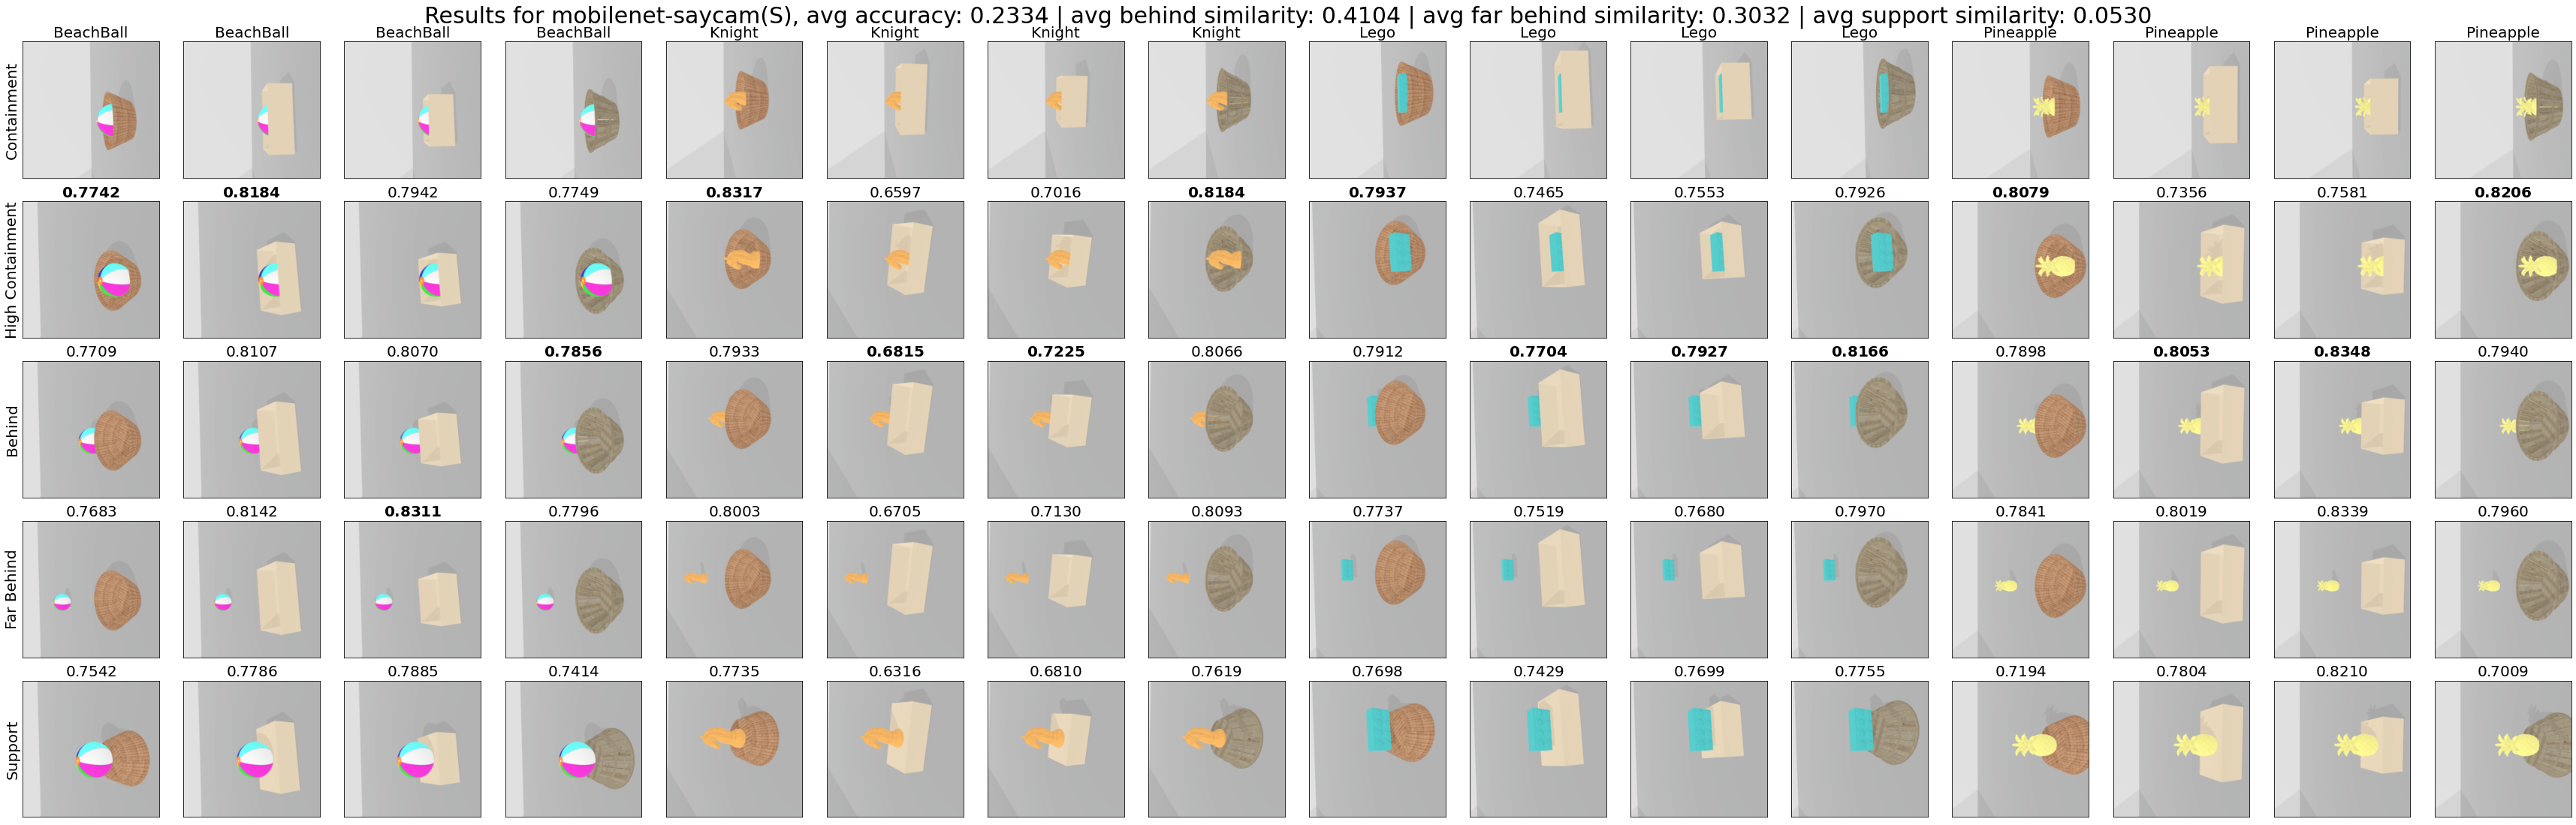

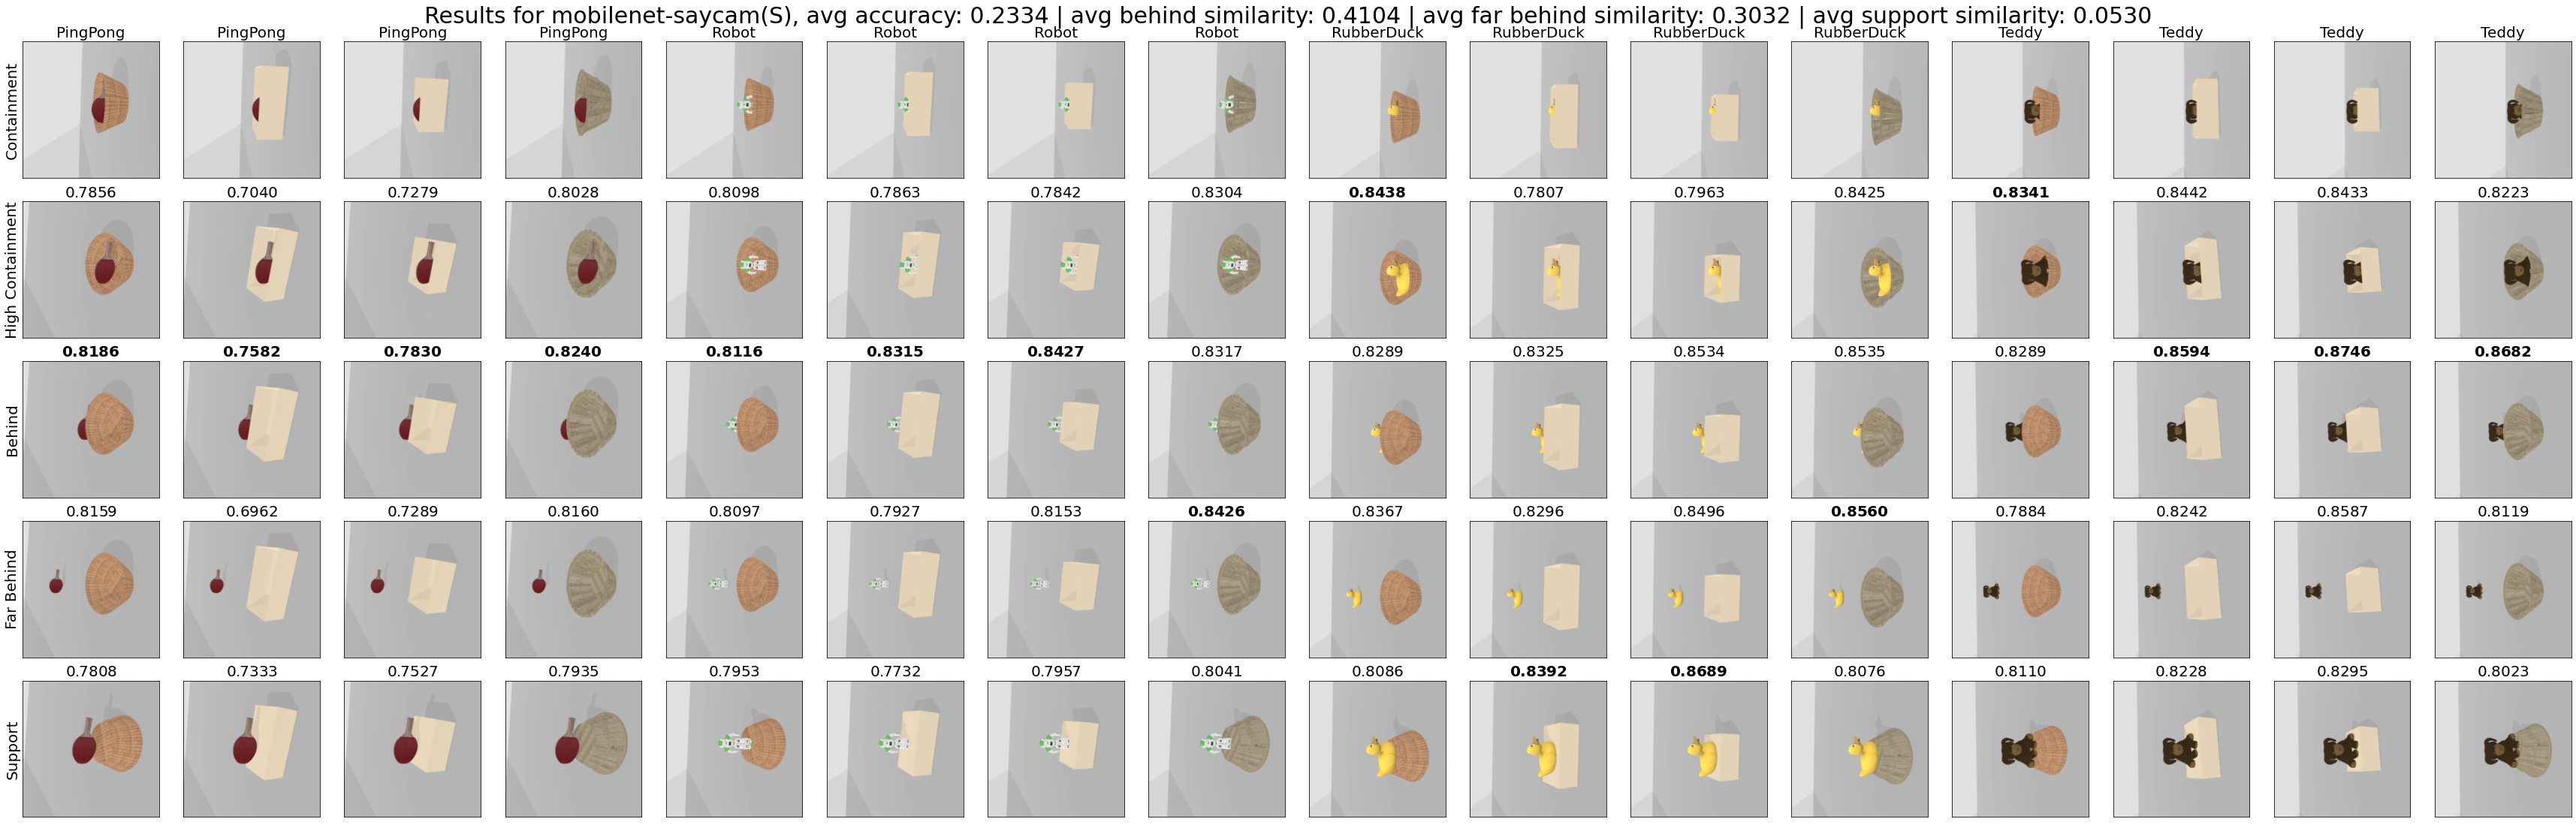

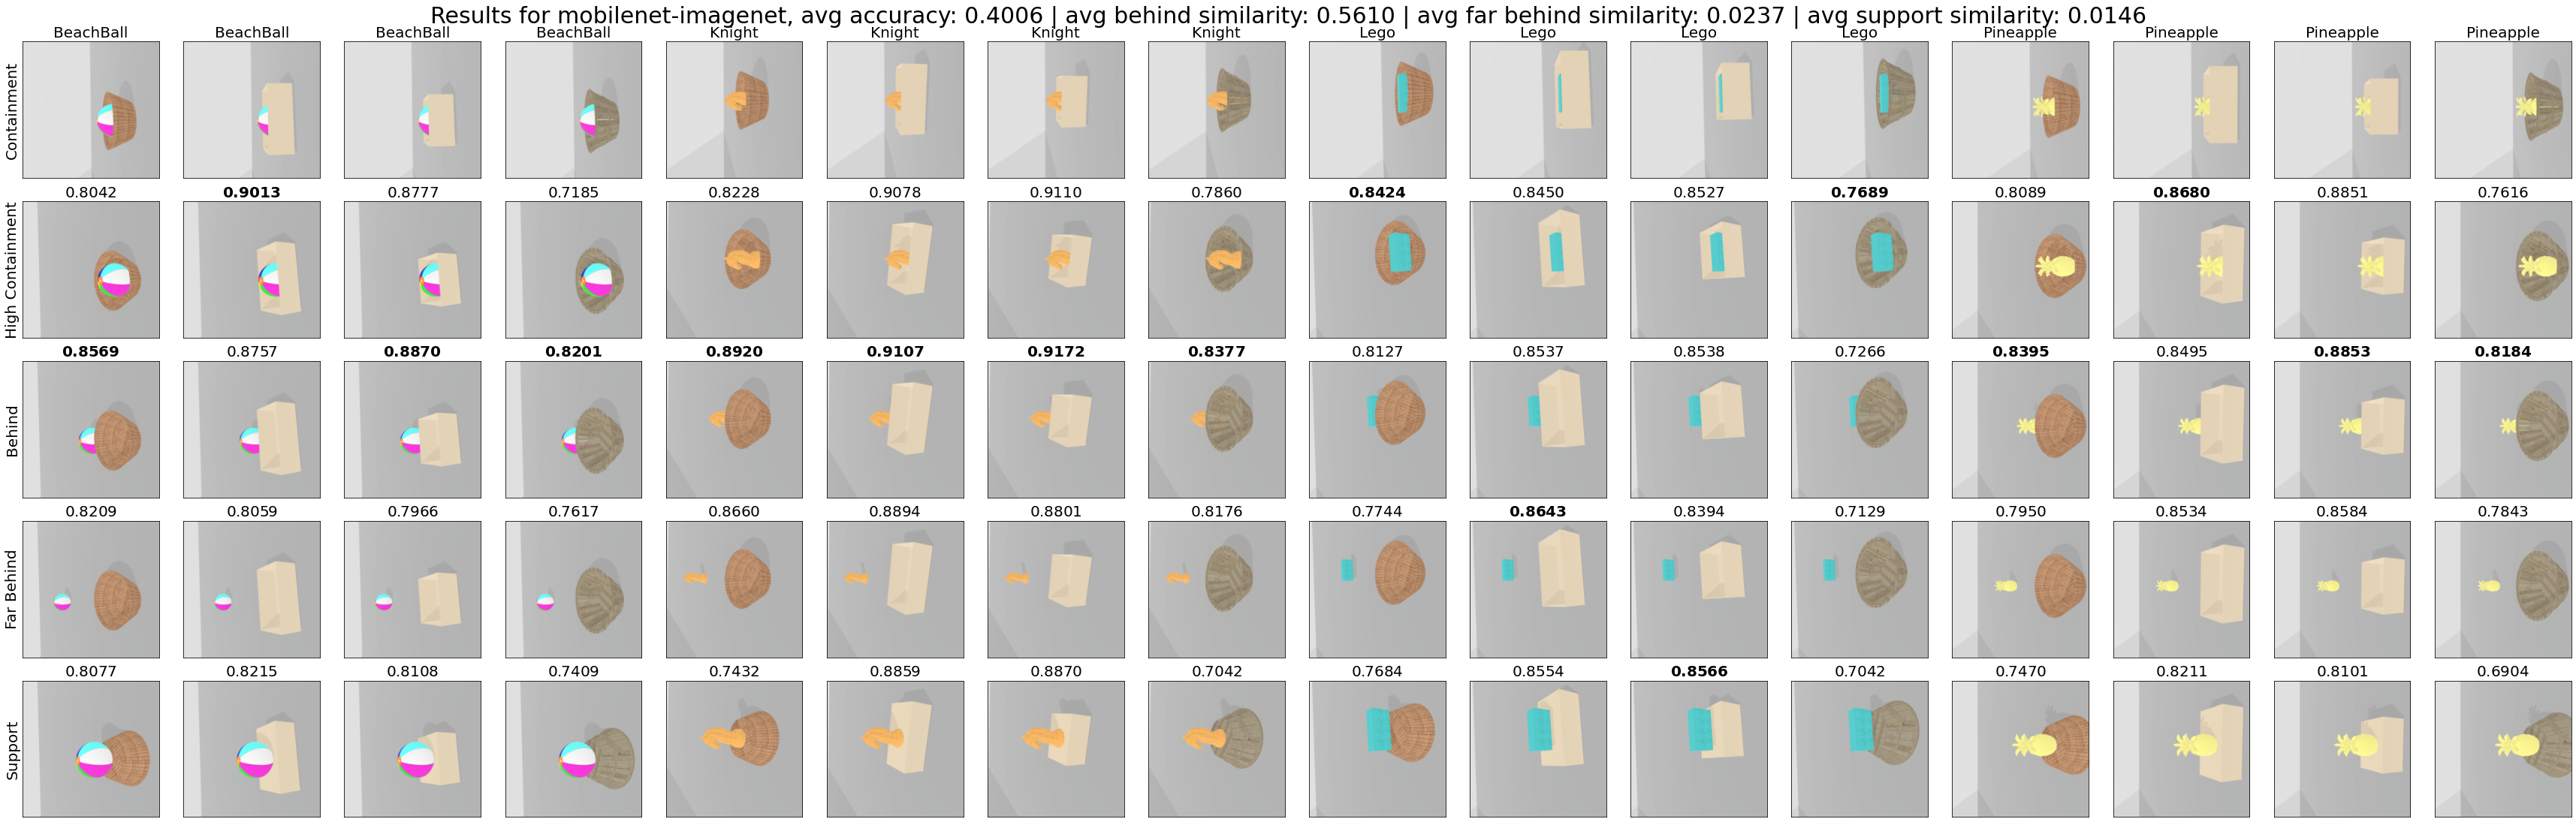

KeyboardInterrupt: 

In [11]:
model_sections = {
    'mobilenet-saycam(S)': 'Baseline MobileNet',
    'resnext-saycam(S)': 'Baseline ResNeXt',
    'resnext-saycam(S)-s': 'Flipping SAYCam Models',
    'resnext-DINO-S': 'DINO Models',
}


def _create_title(df_row: pd.core.series.Series, value_key: str, correct_key: str):  # type: ignore
    correct = df_row[correct_key].values[0]
    if correct:
        return f'$ \\mathbf{{ {row[value_key].values[0]:.4f} }} $'
    else:
        return f'$ {row[value_key].values[0]:.4f} $'


for model in df.full_model_name.unique():  # type: ignore
    if model in model_sections:
        display(Markdown(f'## {model_sections[model]}'))  

    full_indices = []
    n_target_objects = len(dataset.target_objects)
    n_reference_objects = len(set(dataset.dataset_reference_objects))
    for target_object_index in range(n_target_objects):
        for reference_object_index in range(n_reference_objects):
            full_indices.append(target_object_index * (n_target_objects * n_reference_objects + 1) + (reference_object_index * n_target_objects))

    midpoint = len(full_indices) // 2

    for indices in (full_indices[:midpoint], full_indices[midpoint:]):
        examples = UNNORMALIZE(dataset.dataset[indices]).transpose(0, 1)

        titles_by_row = [[], [], [], [], []]

        for idx in indices:
            ref = dataset.dataset_reference_objects[idx]
            target = dataset.dataset_target_objects[idx]
            config = dataset.dataset_configuration_indices[idx]

            row = df.loc[(df['reference_object'] == ref) & (df['target_object'] == target) & (df['configuration_index'] == config) & (df['full_model_name'] == model)]
            if len(row) != 1:
                raise Exception('Invalid row')

            titles_by_row[0].append(target)
            titles_by_row[1].append(_create_title(row, 'containment_high_containment_cos', 'high_containment_similar'))
            titles_by_row[2].append(_create_title(row, 'containment_behind_cos', 'behind_similar'))
            titles_by_row[3].append(_create_title(row, 'containment_far_behind_cos', 'far_behind_similar'))
            titles_by_row[4].append(_create_title(row, 'containment_support_cos', 'support_similar'))

        plot_triplets(examples.transpose(-1, -2), 
            custom_titles=titles_by_row,
            row_titles=['Containment', 'High Containment', 'Behind', 'Far Behind', 'Support'],
            suptitle=f'Results for {model}, avg accuracy: {df.loc[df["full_model_name"] == model]["high_containment_similar"].mean():.4f} | avg behind similarity: {df.loc[df["full_model_name"] == model]["behind_similar"].mean():.4f} | avg far behind similarity: {df.loc[df["full_model_name"] == model]["far_behind_similar"].mean():.4f} | avg support similarity: {df.loc[df["full_model_name"] == model]["support_similar"].mean():.4f}',  # type: ignore
            title_kwargs=dict(fontsize=20), title_every_image=True)

In [ ]:
dataset.dataset.shape

In [ ]:
train_indices = np.arange(15)
train = dataset.dataset[train_indices]
tr = train.view(-1, *train.shape[2:])
print(train.shape, tr.shape)

In [ ]:
tr[5] == train[1, 0]